# Detecting Anomalous Market Stress Periods (2007-2009)

- **Task:** Anomaly Detection (using statistical method, thresholds based on rolling statistics and an unsupervised learning algorithm, Isolation Forest).
- **Data Source:** Federal Reserve Economic Data (FRED) database, accessed via API (`fredapi`). Daily data covering the period from January 1, 2007, to December 31, 2009.
- **Features:** A selection of important daily market stress indicators:
    - _Market Volatility:_ CBOE Volatility Index (VIX - Ticker: `VIXCLS`). Measures expected market volatility.
    - _Credit Risk / Interbank Stress:_
        - TED Spread (Ticker: `TEDRATE`): Reflects the spread between 3-month USD LIBOR and 3-month T-Bills. Indicates perceived credit risk in the general economy.
        - ICE BofA US High Yield Index Option-Adjusted Spread (Ticker: `BAMLH0A0HYM2`): Reflects the premium demanded for holding risky corporate debt (High Yield Spread).

- **Unsupervised Learning Problem:** The core task is to identify days where the market stress indicators exhibit anomalous behavior *without* pre-defined labels of what constitutes a crisis day. I use an unsupervised algorithm (Isolation Forest) alongside a statistical baseline to detect these deviations.

**Goal:** To identify specific dates or short periods between 2007 and 2009 where multiple stress indicators simultaneously exhibited anomalous behavior (e.g., extreme high values or rapid increases). The identified anomalies will then be correlated with significant events of the financial crisis timeline, such as the near-collapse of Bear Stearns (March 2008), the bankruptcy of Lehman Brothers (September 15, 2008), or the AIG bailout (September 16, 2008).

## Step 1 & 2: Imports and Fetching Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from fredapi import Fred
from sklearn.ensemble import IsolationForest

api_key = 'hey_there_use_your_api_key_here :)'

# Initialize the Fred client
fred = Fred(api_key=api_key)


# Define parameters
start_date = '2007-01-01'
end_date = '2009-12-31'
tickers = {
    'VIX': 'VIXCLS',
    'TED': 'TEDRATE',
    'HY_Spread': 'BAMLH0A0HYM2'
}

# Fetch data for each ticker
print(f"Fetching data...")
data = {}
fetch_errors = False
for name, code in tickers.items():
    # Fetch the series
    series = fred.get_series(code, observation_start=start_date, observation_end=end_date)
    series.name = name
    data[name] = series
print(f"Fetching completed!")

Fetching data...
Fetching completed!


## Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean

### 3a. Combine Data & Handle Missing Values

In [2]:
# --- Data Preparation ---

# Combine into a single DataFrame
df = pd.concat(data.values(), axis=1, keys=data.keys())
df.index.name = 'Date'

print("\n--- Data Structure ---")
print(f"DataFrame Shape: {df.shape}")
print("DataFrame Head:\n", df.head())
print("\nDataFrame Info:")
df.info()

# --- Handle Missing Data ---
print("\n--- Missing Data Check ---")
missing_values = df.isnull().sum()
print("Missing values per column BEFORE handling:\n", missing_values)

if missing_values.sum() > 0:
    # Forward fill, assuming the value carries over from the previous day (e.g., weekends/holidays)
    df_filled = df.ffill()

    # Check if ffill left any NaNs
    remaining_nans_after_ffill = df_filled.isnull().sum()
    if remaining_nans_after_ffill.sum() > 0:
        df_filled = df_filled.bfill() # Backfill to handle any remaining NaNs at the start

    final_missing = df_filled.isnull().sum()
    print("\nMissing values per column AFTER handling:\n", final_missing)

    if final_missing.sum() == 0:
        print("Successfully handled all missing values.")
        df = df_filled
    else:
        print("\nWarning: Could not fill all missing values!!!! AAAAAA")
        df = df_filled
else:
    print("No missing values found.")
    final_missing = missing_values



--- Data Structure ---
DataFrame Shape: (794, 3)
DataFrame Head:
               VIX   TED  HY_Spread
Date                              
2007-01-01    NaN   NaN        NaN
2007-01-02    NaN  0.42       2.91
2007-01-03  12.04  0.44       2.91
2007-01-04  11.51  0.45       2.95
2007-01-05  12.14  0.44       2.93

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2007-01-01 to 2009-12-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   VIX        756 non-null    float64
 1   TED        739 non-null    float64
 2   HY_Spread  784 non-null    float64
dtypes: float64(3)
memory usage: 24.8 KB

--- Missing Data Check ---
Missing values per column BEFORE handling:
 VIX          38
TED          55
HY_Spread    10
dtype: int64

Missing values per column AFTER handling:
 VIX          0
TED          0
HY_Spread    0
dtype: int64
Successfully handled all missing values.


### 3b. Feature Distributions

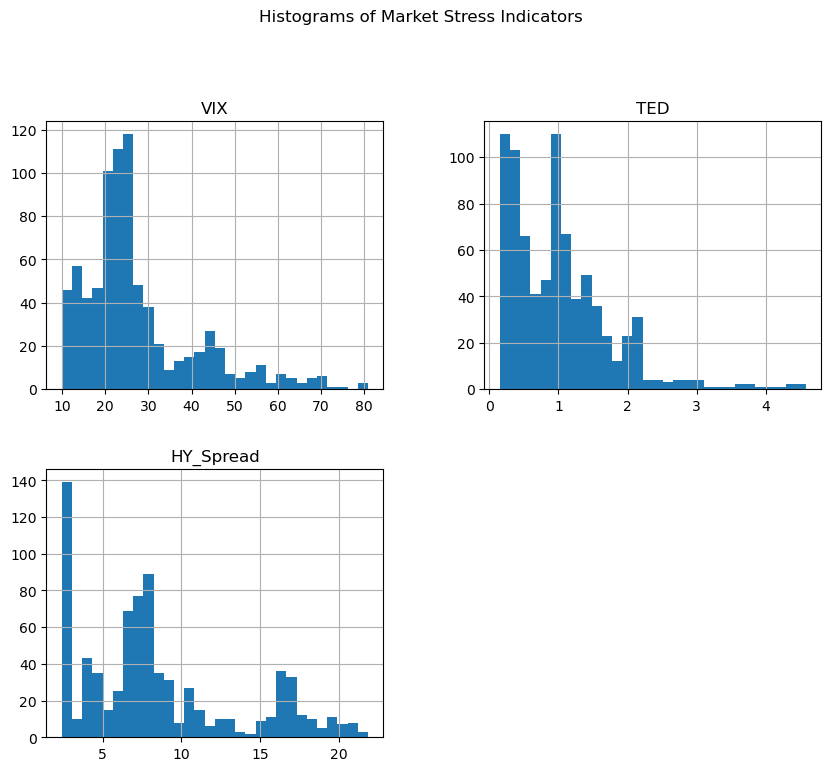

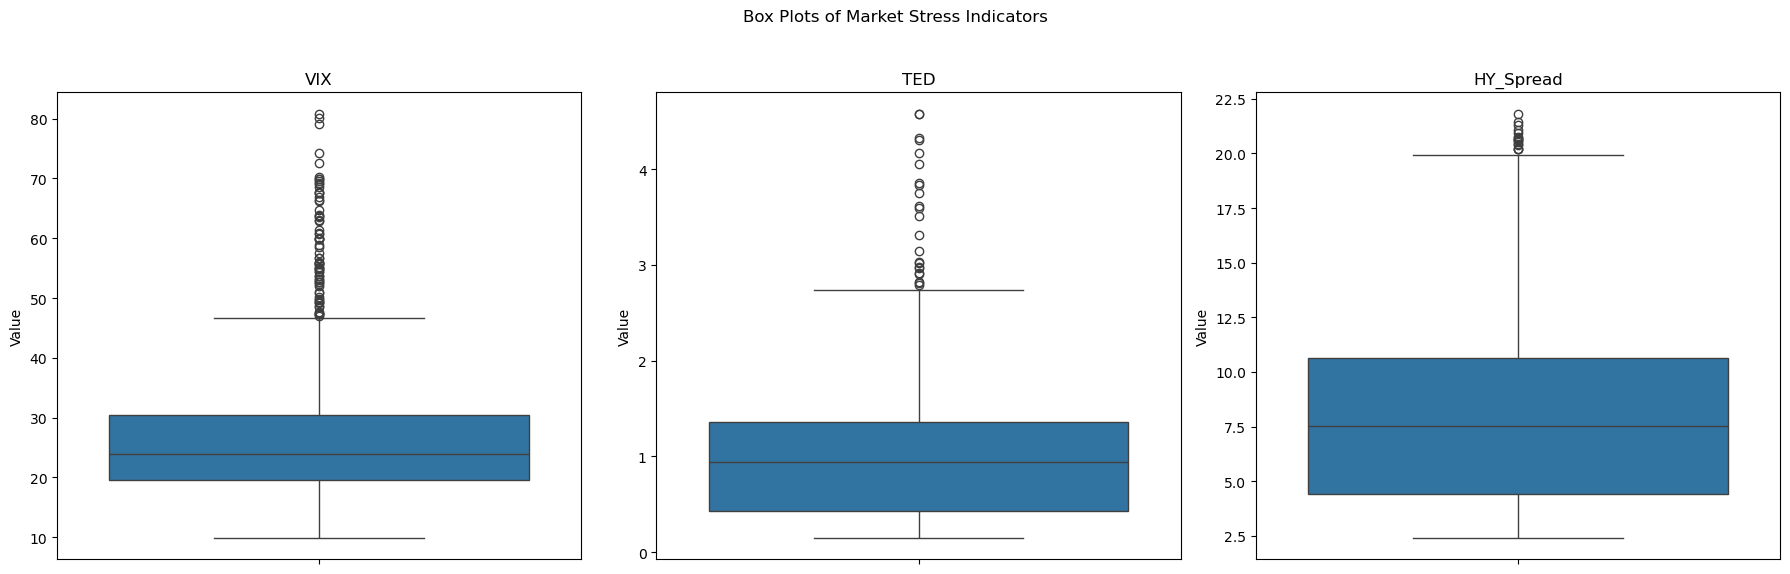

In [3]:
# Histograms
df.hist(figsize=(10, 8), bins=30)
plt.suptitle('Histograms of Market Stress Indicators', y=1.02)
plt.show()

# Box Plots
fig, axes = plt.subplots(1, len(df.columns), figsize=(18, 6), sharey=False)
fig.suptitle('Box Plots of Market Stress Indicators')
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Value')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Observations on Distributions:**
*   The histograms and box plots show that all three indicators (VIX, TED, HY_Spread) are right-skewed, which is typical for financial stress indicators.
*   The scales of the indicators are quite different, particularly VIX which reaches much higher absolute values than TED or HY_Spread. This is clear in both the `describe()` output and the box plots.
*   The box plots clearly highlight the presence of numerous outliers, especially during the crisis period.

### 3c. Feature Correlations


Correlation Matrix:
                 VIX       TED  HY_Spread
VIX        1.000000  0.565076   0.897179
TED        0.565076  1.000000   0.342486
HY_Spread  0.897179  0.342486   1.000000


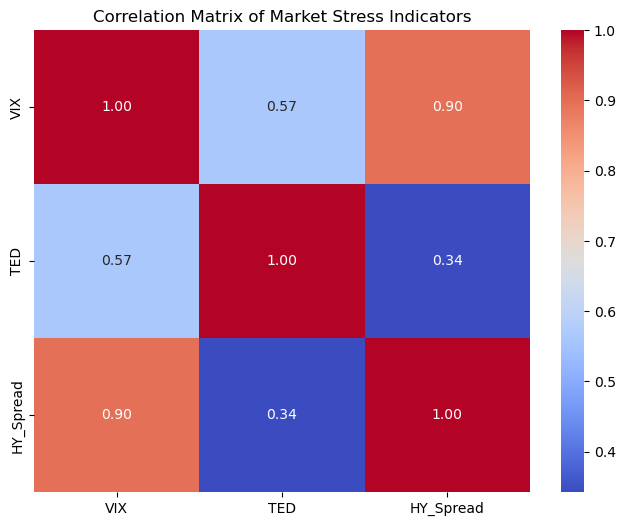

In [4]:
correlation_matrix = df.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Market Stress Indicators')
plt.show()


**Observations on Correlations:**
*   As expected, the market stress indicators show positive correlations with each other.

### 3d. Data Transformation Considerations

**Need for Transformation (e.g., Scaling):**
*   The `describe()` output and box plots showed significantly different scales between features (e.g., VIX max ~80, TED max ~4.6, HY_Spread max ~22).
*   **For the Statistical Method:** This method calculates thresholds based on each indicator's own rolling statistics (mean and standard deviation). Therefore, scaling is *not* necessary, as each series is treated relative to its own history.
*   **For Isolation Forest:** While Isolation Forest is generally considered less sensitive to feature scaling, extreme differences in scales *could* potentially bias the feature splits towards the feature with the largest variance. However, given the nature of the algorithm (random splits), I'll proceed *without* scaling to keep the interpretation straightforward and aligned with the statistical method.
*   **Log Transformation:** Given the right-skewness, a log transform could potentially make the distributions more symmetric. However, for anomaly detection focused on *extreme high values*, working with the original scale might be more intuitive for setting thresholds and interpreting results.

### 3e. Outlier Handling

In this context, 'outliers' are precisely the phenomena we aim to detect, therefore, I do not remove outliers during the EDA phase.

### 3f. Initial Time Series Visualization

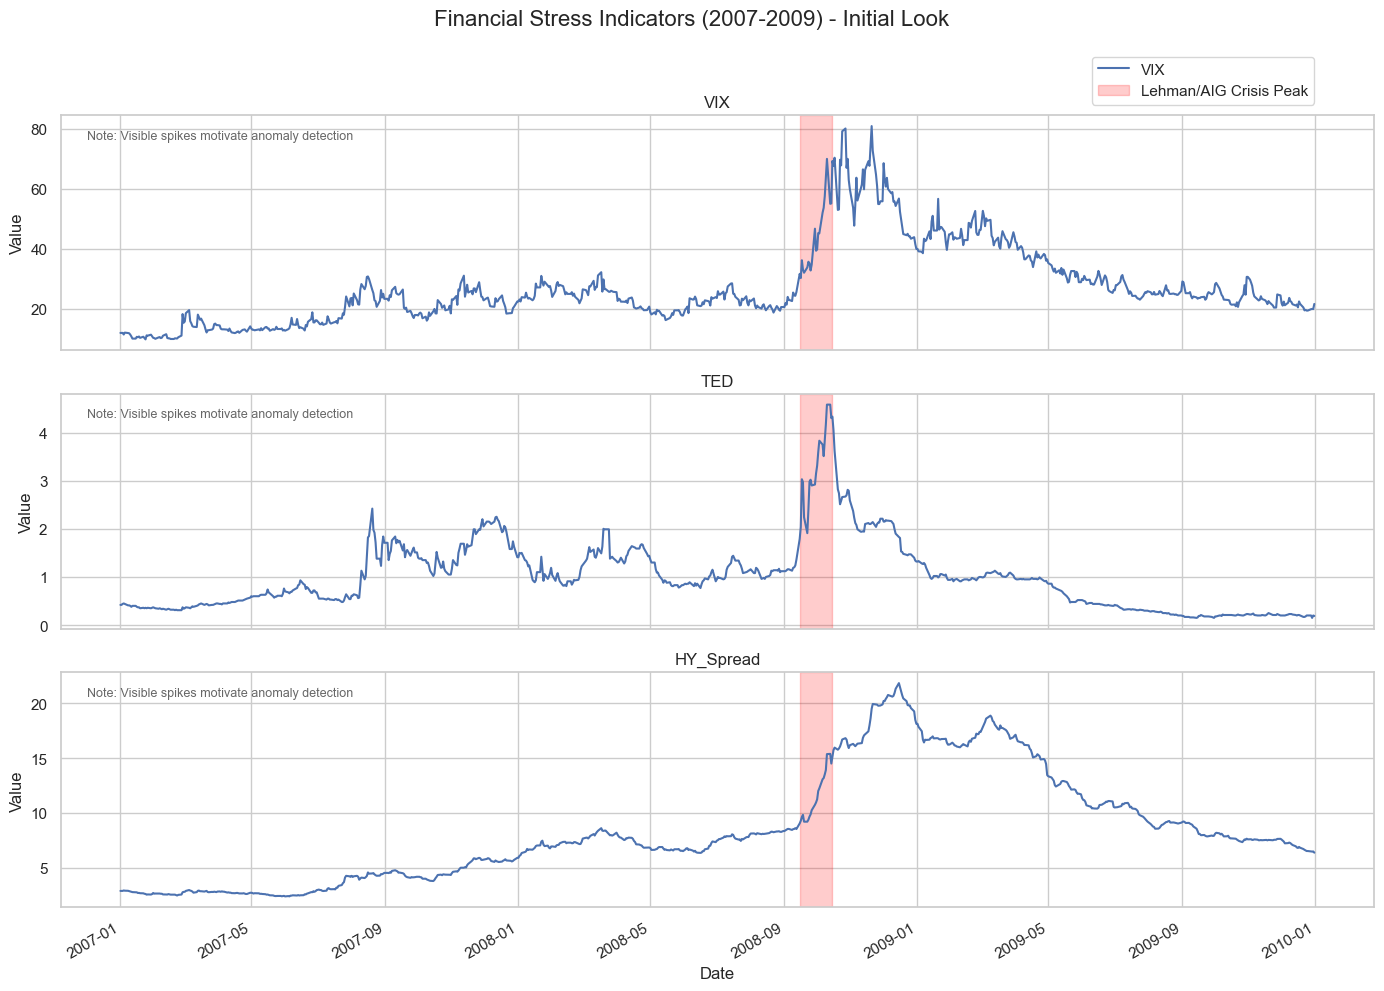

In [5]:
# Set seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(14, 10), sharex=True)
fig.suptitle('Financial Stress Indicators (2007-2009) - Initial Look', fontsize=16, y=0.99)

# Plot each indicator
for i, col in enumerate(df.columns):
    if col in df.columns:
        ax = axes[i]
        df[col].plot(ax=ax, title=col, grid=True, legend=False)
        ax.set_ylabel('Value')
        # Highlight the Lehman Brothers bankruptcy period for context
        ax.axvspan('2008-09-15', '2008-10-15', color='red', alpha=0.2, label='Lehman/AIG Crisis Peak' if i == 0 else "")
        # Acknowledge visible spikes
        ax.text(0.02, 0.9, 'Note: Visible spikes motivate anomaly detection', transform=ax.transAxes, fontsize=9, alpha=0.7)
    else:
        print(f"Column '{col}' not found for plotting.")

if len(axes)>0:
    axes[-1].set_xlabel('Date')

# Add a single legend for the highlighted span
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to prevent title overlap
plt.show()



## Step 4: Perform Analysis Using Unsupervised Learning Models

I'll use two methods to detect anomalies:
1.  **Statistical Thresholds:** A baseline method using rolling means and standard deviations. An anomaly is flagged if an indicator exceeds its recent mean by a certain number of standard deviations.
2.  **Isolation Forest:** It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Anomalies are expected to be isolated in fewer splits.


### 4a. Hyperparameter Selection Discussion

**Statistical Method:**
*   `rolling_window = 60`: Chosen to represent approximately 3 months of trading days (roughly 20 days/month). This provides a balance between adapting to recent market conditions and having enough data for stable statistics. Shorter windows might be too noisy, longer windows too slow to react.
*   `std_dev_threshold = 3.0`: Points more than 3 standard deviations from the mean are often considered unusual.
*   `min_indicators_anomalous = 2`: This parameter operationalizes the hypothesis that simultaneous stress across multiple indicators is more significant. Requiring at least 2 indicators to flag reduces noise from isolated spikes in a single series.

**Isolation Forest:**
*   `n_estimators = 100`: Represents the number of base estimators (trees) in the ensemble. 100 is a standard default in scikit-learn.
*   `contamination = 0.03`: This parameter estimates the proportion of outliers in the dataset. Setting it to 0.03 assumes roughly 3% of the data points might be anomalous. This is an estimate based on the visual inspection of the time series (spikes appear relatively infrequent but significant).

In [6]:
# --- Configuration for Anomaly Detection ---
rolling_window = 60      # Days for rolling statistics (approx. 3 months of trading days)
std_dev_threshold = 3.0  # Number of standard deviations for statistical threshold
min_indicators_anomalous = 2 # How many indicators must be anomalous for a day to be flagged statistically

df_analysis = df.copy()

# --- Method 1: Statistical Thresholds ---
print(f"\n--- Running Statistical Threshold Anomaly Detection (Window={rolling_window}, Sigma={std_dev_threshold}) ---")

anomalies_stat = pd.DataFrame(index=df_analysis.index)

for col in df.columns: # Iterate over original columns only
    # Calculate rolling mean and std deviation
    rolling_mean = df_analysis[col].rolling(window=rolling_window, min_periods=1).mean()
    rolling_std = df_analysis[col].rolling(window=rolling_window, min_periods=1).std()

    threshold = rolling_mean + (std_dev_threshold * rolling_std)

    df_analysis[f'{col}_rolling_mean'] = rolling_mean
    df_analysis[f'{col}_rolling_std'] = rolling_std
    df_analysis[f'{col}_threshold'] = threshold

    # Identify anomalies for indicator
    # A point is anomalous if it's above the threshold AND the std dev is not NaN/zero (to avoid division by zero issues or flagging flat lines)
    is_anomalous = (df_analysis[col] > threshold) & (rolling_std.notna()) & (rolling_std > 1e-6)
    anomalies_stat[f'{col}_Anom'] = is_anomalous
    print(f"Indicator '{col}': Found {is_anomalous.sum()} potential anomalies.")


# Combine signals -> Flag day if at least 'min_indicators_anomalous' are anomalous
anomalies_stat['Anomaly_Count_Stat'] = anomalies_stat[[f'{col}_Anom' for col in df.columns]].sum(axis=1)
df_analysis['Stat_Anomaly'] = (anomalies_stat['Anomaly_Count_Stat'] >= min_indicators_anomalous)

# Get the dates flagged as anomalous
stat_anomaly_dates = df_analysis[df_analysis['Stat_Anomaly']].index
print(f"\nTotal days flagged by Statistical Method (>= {min_indicators_anomalous} indicators): {len(stat_anomaly_dates)}")


# --- Method 2: Isolation Forest ---
print(f"\n--- Running Isolation Forest Anomaly Detection ---")

# Initialize and fit the model
iforest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)

# Fit the model and predict outliers
# Pass the original indicator columns
predictions = iforest.fit_predict(df_analysis[df.columns])

# Add predictions to the DataFrame (-1 indicates anomaly, 1 indicates normal)
df_analysis['IF_Anomaly_Pred'] = predictions
df_analysis['IF_Anomaly'] = df_analysis['IF_Anomaly_Pred'] == -1

# Get the dates flagged as anomalous
if_anomaly_dates = df_analysis[df_analysis['IF_Anomaly']].index
print(f"Total days flagged by Isolation Forest: {len(if_anomaly_dates)}")


# --- Summarize Anomalies ---
print("\n--- Anomaly Detection Summary ---")
print(f"Statistical Method Anomalies: {df_analysis['Stat_Anomaly'].sum()}")
print(f"Isolation Forest Anomalies:   {df_analysis['IF_Anomaly'].sum()}")

# Lists of anomalous dates:
statistical_anomalies = df_analysis[df_analysis['Stat_Anomaly']].index
isolation_forest_anomalies = df_analysis[df_analysis['IF_Anomaly']].index

print(f"\n\nstatistical_anomalies:\n{statistical_anomalies}")
print(f"\n\nisolation_forest_anomalies:\n{isolation_forest_anomalies}")



--- Running Statistical Threshold Anomaly Detection (Window=60, Sigma=3.0) ---
Indicator 'VIX': Found 20 potential anomalies.
Indicator 'TED': Found 12 potential anomalies.
Indicator 'HY_Spread': Found 21 potential anomalies.

Total days flagged by Statistical Method (>= 2 indicators): 13

--- Running Isolation Forest Anomaly Detection ---
Total days flagged by Isolation Forest: 24

--- Anomaly Detection Summary ---
Statistical Method Anomalies: 13
Isolation Forest Anomalies:   24


statistical_anomalies:
DatetimeIndex(['2007-07-26', '2007-07-27', '2007-08-10', '2008-09-15',
               '2008-09-16', '2008-09-17', '2008-09-18', '2008-09-29',
               '2008-10-06', '2008-10-07', '2008-10-08', '2008-10-09',
               '2008-10-10'],
              dtype='datetime64[ns]', name='Date', freq=None)


isolation_forest_anomalies:
DatetimeIndex(['2008-09-17', '2008-09-25', '2008-09-29', '2008-09-30',
               '2008-10-01', '2008-10-02', '2008-10-03', '2008-10-06',
           

### 4b. Visualize Results and Compare Models

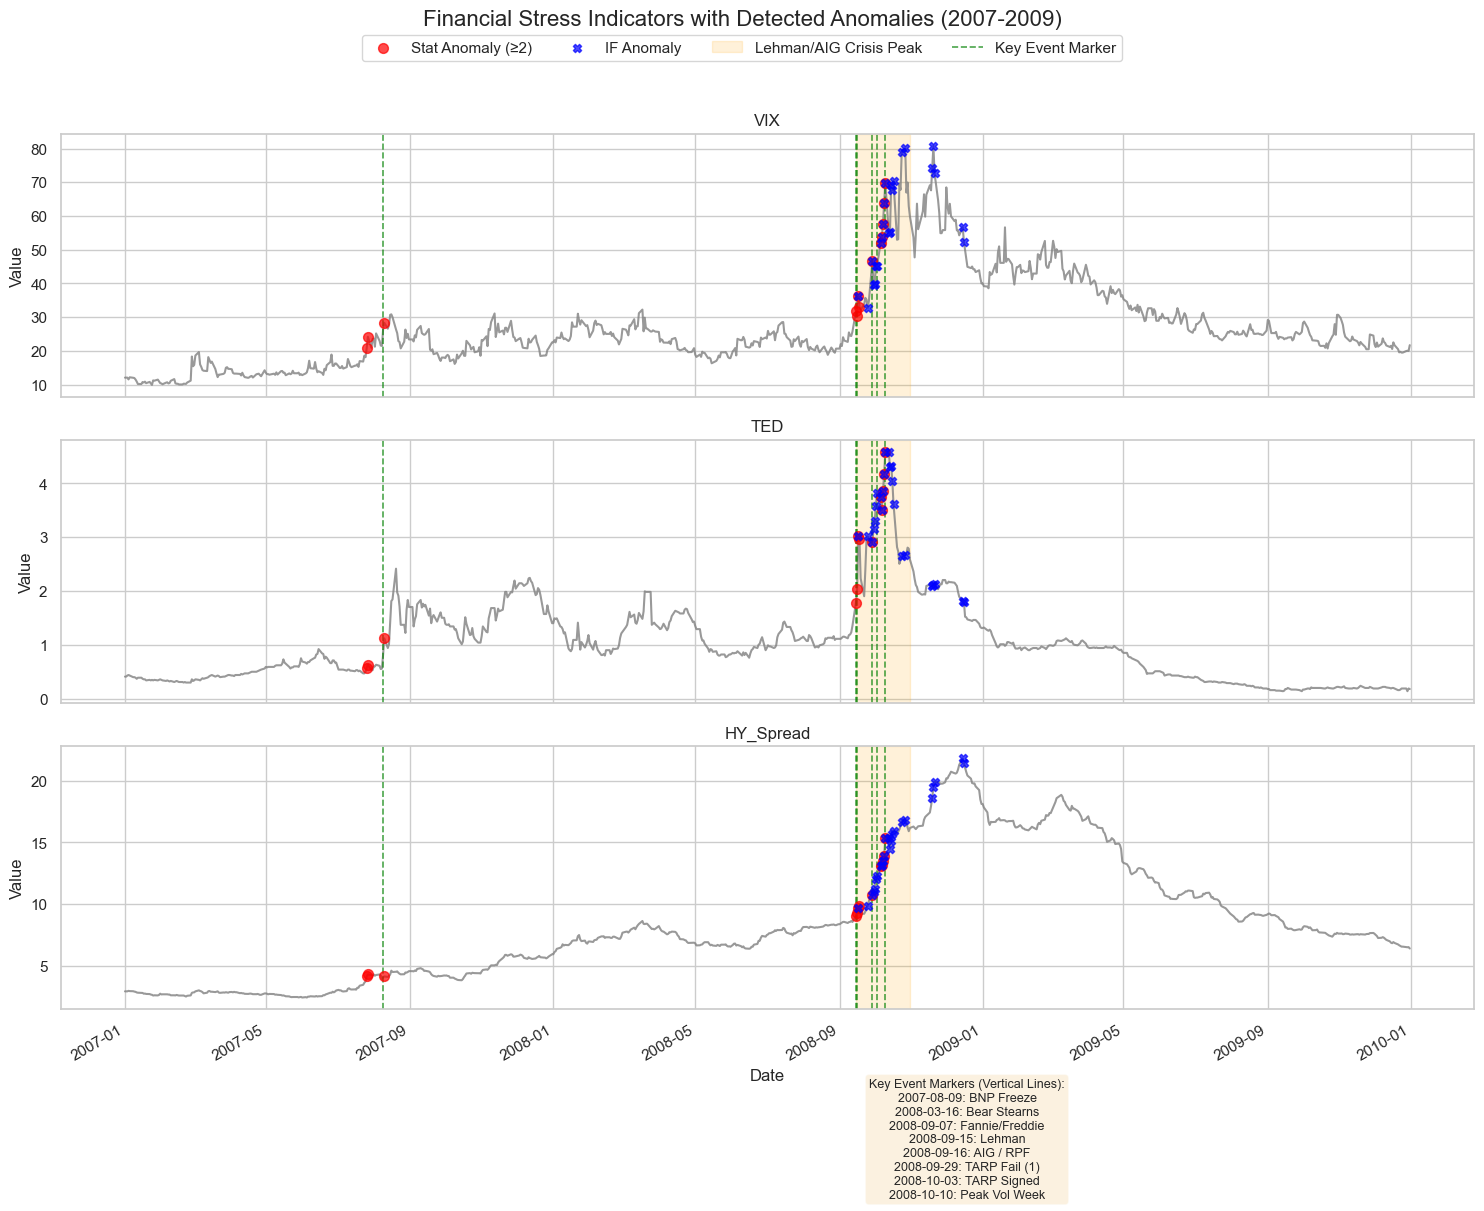

In [7]:
# Define key crisis event dates
crisis_events = {
    pd.to_datetime('2007-08-09'): 'BNP Freeze',
    pd.to_datetime('2008-03-16'): 'Bear Stearns',
    pd.to_datetime('2008-09-07'): 'Fannie/Freddie',
    pd.to_datetime('2008-09-15'): 'Lehman',
    pd.to_datetime('2008-09-16'): 'AIG / RPF', # RPF = Reserve Primary Fund
    pd.to_datetime('2008-09-29'): 'TARP Fail (1)',
    pd.to_datetime('2008-10-03'): 'TARP Signed',
    pd.to_datetime('2008-10-10'): 'Peak Vol Week',
}

# Create subplots
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 12), sharex=True)
fig.suptitle('Financial Stress Indicators with Detected Anomalies (2007-2009)', fontsize=16, y=0.99)

# Set marker styles for anomalies
stat_marker = 'o'
if_marker = 'X'
marker_size = 50

for i, col in enumerate(df.columns):
    ax = axes[i]
    # Plot the main time series
    df_analysis[col].plot(ax=ax, label='_nolegend_', grid=True, color='grey', alpha=0.8)

    # Highlight anomalies detected by Statistical Method
    if 'Stat_Anomaly' in df_analysis.columns:
        stat_anomalies_on_series = df_analysis[df_analysis['Stat_Anomaly']]
        if not stat_anomalies_on_series.empty:
            ax.scatter(stat_anomalies_on_series.index, stat_anomalies_on_series[col],
                       color='red', marker=stat_marker, s=marker_size, label=f'Stat Anomaly (≥{min_indicators_anomalous})', alpha=0.7, zorder=5)

    # Highlight anomalies detected by Isolation Forest
    if 'IF_Anomaly' in df_analysis.columns:
        if_anomalies_on_series = df_analysis[df_analysis['IF_Anomaly']]
        if not if_anomalies_on_series.empty:
             ax.scatter(if_anomalies_on_series.index, if_anomalies_on_series[col],
                       color='blue', marker=if_marker, s=marker_size-15, label='IF Anomaly', alpha=0.7, zorder=6) # zorder=6 to plot on top

    ax.set_title(col)
    ax.set_ylabel('Value')

    # Add the crisis highlight span
    ax.axvspan('2008-09-15', '2008-10-31', color='orange', alpha=0.15, label='Lehman/AIG Crisis Peak' if i == 0 else "")

    # --- Add Event Markers (Vertical Lines) ---
    for date, label in crisis_events.items():
        if (pd.to_datetime(start_date) <= date <= pd.to_datetime(end_date)) and (date in df_analysis.index):
             ax.axvline(date, color='green', linestyle='--', linewidth=1.2, alpha=0.7, 
                       label='Key Event Marker' if (i == 0 and date == list(crisis_events.keys())[0]) else "") # Label only once

# Create a combined legend outside the plots
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        if label not in labels and label != '_nolegend_':
            handles.append(handle)
            labels.append(label)

# Adjust ncol dynamically based on number of labels
num_labels = len(labels)
ncol_legend = min(num_labels, 4)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.975), ncol=ncol_legend)

# Add separate text block below the legend for the event details
event_text = "Key Event Markers (Vertical Lines):\n" + \
                "\n".join([f"{date.strftime('%Y-%m-%d')}: {name}" for date, name in crisis_events.items()])

plt.figtext(0.65, 0.001, event_text, ha="center", fontsize=9, wrap=True, # Positioned at the bottom
            bbox={"boxstyle": "round,pad=0.3", "facecolor": "wheat", "alpha": 0.4})

axes[-1].set_xlabel('Date')
plt.tight_layout(rect=[0, 0.08, 1, 0.95]) # Adjust rect for legend and text box
plt.show()


### 4c. Model Comparison

**Comparing Statistical Thresholds vs. Isolation Forest:**

*   **Overlap:** Both methods successfully identify the peak crisis period around September/October 2008 (following the Lehman Brothers bankruptcy and AIG bailout) as highly anomalous. The visual plot shows significant overlap between the red circles (Statistical) and blue crosses (Isolation Forest) during this time.
*   **Sensitivity & Scope:**
    *   The **Statistical Method** flags fewer anomalies overall. It appears more focused on periods where at least two indicators *simultaneously* made sharp, statistically significant moves *relative to their recent past* (the 60-day window). This makes it good at detecting sharp escalations.
    *   **Isolation Forest** flags more days as anomalous, including some periods slightly earlier in 2008 and later spikes. This suggests it might be capturing broader deviations from the overall data structure, not just relative to the immediate rolling window. It considers the combination of feature values across the entire dataset when determining isolation difficulty. The `contamination` parameter directly influences how many points are flagged.
*   **Interpretation:**
    *   The statistical method provides a clear interpretation based on standard deviations from a rolling mean, making it easy to understand *why* a point is flagged (e.g., "VIX was > 3 std devs above its 60-day mean").
    *   Isolation Forest's anomalies are based on the concept of being 'easier to isolate'. While effective, the exact reason *why* a specific point was isolated might be less direct than the statistical threshold.
*   **Alignment with Events:** Both methods highlight the period surrounding major known crisis events (Lehman, AIG, TARP). The Isolation Forest also flags some dates around the Bear Stearns event (March 2008) and earlier stress related to the BNP Paribas freeze (August 2007), though the statistical method (requiring 2+ indicators) is less sensitive here.

### 4d. Conclusions

This analysis successfully applied both a statistical thresholding method and an unsupervised learning algorithm (Isolation Forest) to detect anomalous market stress periods between 2007 and 2009 using key indicators (VIX, TED Spread, High Yield Spread) from the FRED database.

**Key Findings:**
1.  **Successful Anomaly Detection:** Both methods effectively identified periods of heightened market stress, particularly the acute phase of the Global Financial Crisis in late 2008.
2.  **Alignment with Historical Events:** The detected anomalies, especially those identified by both methods, strongly correlate with major known events of the financial crisis timeline, including the Lehman Brothers bankruptcy, the AIG bailout, and the subsequent period of extreme volatility ('Peak Vol Week').
3.  **Complementary Methods:** The statistical method highlighted sharp, simultaneous deviations relative to recent history, while Isolation Forest captured potentially broader structural anomalies. The combination provided a more comprehensive view than either method alone.
4.  **EDA Insights:** Exploratory Data Analysis confirmed the right-skewed nature of stress indicators, their positive correlations, and the presence of significant outliers (the anomalies themselves), validating the choice of methods.

**Limitations and Future Work:**
*   **Parameter Sensitivity:** The results depend on parameter choices (e.g., `rolling_window`, `std_dev_threshold`, `contamination`). Further work could involve sensitivity analysis or more sophisticated hyperparameter tuning.
*   **Feature Selection:** Only three indicators were used. Incorporating additional relevant indicators (e.g., other credit spreads, funding stress measures) could provide a richer analysis.
*   **Scaling Impact:** While not implemented here, testing the impact of feature scaling on the Isolation Forest results could be explored.